# Imports

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logomaker as lm

## Conservation functions
All the functions to get the conservation patterns

In [2]:
# %load conservation_functions.py
# Functions for importing the alignment and computing conservation patterns

# read_fasta -- my own little function for reading fasta files output by the MAFFT server
# a_a_entropy -- calculates the entropy for a list of single letter amino acid codes
# find_most_common -- returns the most common value of a list. If there's more than one value meeting that criterion, it will return them both, but that won't be an issue
# group_conservation_column -- for a column, calculates which groups are conserved
# group_conservation_alignment -- basically a wrapper for group_conservation_column
# remove_alignment_gaps -- maps sequence positions to columns in the sequence alignment
# conserved_search -- lets you search through a list of conservation patterns for a group or grouping

def read_fasta(path):
  aligned_sequences = []
  with open(path, 'r') as f:
    aligned_sequences = f.read().split('>')

  aligned_sequences = [line.split('\n') for line in aligned_sequences]
  seq_for_convert = []

  for i in range(1,len(aligned_sequences)):
    tmp_str = ''.join(aligned_sequences[i][1:])
    tmp = (aligned_sequences[i][0], tmp_str)
    seq_for_convert.append(tmp)
  return seq_for_convert

def a_a_entropy(group, chars = {'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-'}):
  counts = []
  for char in chars:
    count = len([x for x in group if x.upper() == char])
    counts.append((char, count))
  frac = [(x, y/len(group)) for (x,y) in counts if y != 0]
  entropy = -sum([y*math.log2(y) for (x,y) in frac])
  return entropy

def find_most_common(some_list):
  uniques = set(some_list)
  counts = []
  for val in uniques:
    count = len([x for x in some_list if x == val])
    counts.append((val, count))
  max_count = max([y for (x,y) in counts])
  most_common = [x for (x,y) in counts if y == max_count]
  return most_common[0]

def group_conservation_column(column_groups, gap_cutoff = 0.1, group_gap_cutoff = 0.3, entropy_cutoff = 2/3):
  full_groups = []
  for group in column_groups:
    full_groups = full_groups + group[1]
  total_gap_frac = len([x for x in full_groups if x == '-'])/len(full_groups)
  if total_gap_frac >= gap_cutoff:
    return 'Gap'
  else:
    group_gap_fracs = []
    for group in column_groups:
      gap_frac = len([x for x in group if x == '-'])/len(group)
      group_gap_fracs.append(gap_frac)
    if max(group_gap_fracs) >= group_gap_cutoff:
      return 'Gap'
    else:
      position_entropy = a_a_entropy(full_groups)
      if position_entropy < 2/3:
        return 'Totally Conserved'
      else:
        group_conservation = [(group[0], a_a_entropy(group[1])) for group in column_groups]
        if min([y for (x,y) in group_conservation]) > entropy_cutoff:
          return 'Not conserved'
        else:
          conserved_groups = set([group[0] for group in group_conservation if group[1] < entropy_cutoff])
          conserved_a_a = [(group[0], find_most_common(group[1])) for group in column_groups if group[0] in conserved_groups]
          conserved_set = set([group[1] for group in conserved_a_a])
          conservation_pattern = [(a_a, [group[0] for group in conserved_a_a if group[1] == a_a])for a_a in conserved_set]
          return conservation_pattern

def group_conservation_alignment(group_list, gap_cutoff = 0.1, group_gap_cutoff = 0.3, entropy_cutoff = 2/3):
  descriptor_output = []
  align_length = len(group_list[0][1][1][1])
  for i in range(align_length):
    column_list = [(group[0],[seq[1][i] for seq in group[1]]) for group in group_list]
    descriptor = group_conservation_column(column_list, gap_cutoff, group_gap_cutoff, entropy_cutoff)
    descriptor_output.append((i, descriptor))
  return descriptor_output

def remove_alignment_gaps(aligned_sequence, initial_value = 1):
  real_aligned_pairing = []
  for i in range(len(aligned_sequence)):
    if aligned_sequence[i] != '-':
      pairing = (len(real_aligned_pairing) + initial_value,i)
      real_aligned_pairing.append(pairing)
  return real_aligned_pairing

def conserved_search(conserved_list, search_term):
  out = []
  for column in conserved_list:
    pattern = column[1]
    if type(search_term) == list:
      for part in pattern:
        if part[1] == search_term:
          out.append(column)
    elif type(search_term) == str:
      for part in pattern:
        if search_term in part[1]:
          out.append(column)
  return out

## Import the alignment
This is the alignment used in the paper. I know which sequences are which protein beforehand.

In [3]:
MAFFT_alignment = read_fasta('Local Files/20200806 MAFFT ABCG small low gap.fasta')
ABCG1_sequences = MAFFT_alignment[:35]
ABCG4_sequences = MAFFT_alignment[35:71]
ABCG2_sequences = MAFFT_alignment[71:103]
ABCG5_sequences = MAFFT_alignment[103:-35]
ABCG8_sequences = MAFFT_alignment[-35:]

# Conservation patterns
The `group_conservation_alignment` function computes the conservation patterns as defined in the paper under "Methods/Calculation of conservation". Each index in the list is a tuple of the column of the alignment and the conservation pattern as defined in the paper. The example here corresponds to R482 in human ABCG2

In [11]:
alignment_protein_conservation = group_conservation_alignment([('ABCG1', ABCG1_sequences), ('ABCG2', ABCG2_sequences), ('ABCG4', ABCG4_sequences), ('ABCG5', ABCG5_sequences), ('ABCG8', ABCG8_sequences)])
alignment_protein_conservation[1011]

(1011,
 [('S', ['ABCG5']),
  ('R', ['ABCG2']),
  ('H', ['ABCG8']),
  ('Q', ['ABCG1', 'ABCG4'])])

### Searching through patterns
The `conserved_search` function allows you to find columns with conservation you're interested in. The example is the first five functionally divergent columns where ABCG1 is conserved.

In [17]:
functionally_divergent = [x for x in alignment_protein_conservation if x[1] not in ['Totally Conserved', 'Gap', 'Not conserved']]
conserved_search(functionally_divergent, 'ABCG1')[0:5]

[(240, [('A', ['ABCG1', 'ABCG4'])]),
 (260, [('P', ['ABCG1', 'ABCG2', 'ABCG4'])]),
 (261, [('K', ['ABCG1']), ('G', ['ABCG4'])]),
 (262, [('S', ['ABCG1', 'ABCG2']), ('A', ['ABCG4'])]),
 (294, [('S', ['ABCG1']), ('A', ['ABCG4'])])]

You can also provide a list, which returns columns where the proteins in your list are a group in the conservation pattern.

In [19]:
conserved_search(functionally_divergent, ['ABCG4', 'ABCG5'])

[(737,
  [('S', ['ABCG2']),
   ('K', ['ABCG4', 'ABCG5']),
   ('L', ['ABCG8']),
   ('Q', ['ABCG1'])]),
 (740,
  [('V', ['ABCG1']), ('L', ['ABCG2', 'ABCG8']), ('I', ['ABCG4', 'ABCG5'])]),
 (810, [('A', ['ABCG4', 'ABCG5'])]),
 (812, [('K', ['ABCG4', 'ABCG5']), ('I', ['ABCG2'])]),
 (814, [('S', ['ABCG4', 'ABCG5']), ('K', ['ABCG8'])]),
 (977, [('K', ['ABCG2']), ('A', ['ABCG4', 'ABCG5'])]),
 (1031, [('D', ['ABCG1']), ('E', ['ABCG4', 'ABCG5'])]),
 (1039,
  [('S', ['ABCG4', 'ABCG5']),
   ('A', ['ABCG1']),
   ('M', ['ABCG2']),
   ('F', ['ABCG8'])])]

Because it returns the same structure of list as the original list of conservation pattern, you can nest searches:

In [20]:
conserved_search(conserved_search(functionally_divergent, 'ABCG1'), ['ABCG4', 'ABCG5'])

[(737,
  [('S', ['ABCG2']),
   ('K', ['ABCG4', 'ABCG5']),
   ('L', ['ABCG8']),
   ('Q', ['ABCG1'])]),
 (740,
  [('V', ['ABCG1']), ('L', ['ABCG2', 'ABCG8']), ('I', ['ABCG4', 'ABCG5'])]),
 (1031, [('D', ['ABCG1']), ('E', ['ABCG4', 'ABCG5'])]),
 (1039,
  [('S', ['ABCG4', 'ABCG5']),
   ('A', ['ABCG1']),
   ('M', ['ABCG2']),
   ('F', ['ABCG8'])])]

## Mapping protein sequences to the alignment
`remove_alignment_gaps` can be used to switch between columns of the alignment and positions in a given protein sequence. The human sequences are:
- ABCG1: MAFFT_alignment 19
- ABCG2: MAFFT_alignment 90
- ABCG4: MAFFT_alignment 35
- ABCG5: MAFFT_alignment 103
- ABCG8: MAFFT_alignment 139

In [22]:
remove_alignment_gaps(MAFFT_alignment[90][1])[481]

(482, 1011)

You can map conservation patterns to your sequence of choice by combining this with `conserved_search` results.

# Protein sequence logos
## Importing the local functions

In [5]:
# %load logo_functions.py
# The functions for generating protein sequence logos summarising the sequence alignment
# protein_logo draws the sequence logo
# conserved_colours generates colours for the sequence logo
def protein_logo(positions):
  """Draws a sequence logo of the positions requested showing differences between ABCG family members

  Arguments:
  positions -- a list of positions within the sequence alignment
  """
  ABCG1 = []
  ABCG2 = []
  ABCG4 = []
  ABCG5 = []
  ABCG8 = []

  for seq in ABCG1_sequences:
    tmp = ''
    for i in positions:
      tmp = tmp + seq[1][i]
    ABCG1.append(tmp)

  for seq in ABCG2_sequences:
    tmp = ''
    for i in positions:
      tmp = tmp + seq[1][i]
    ABCG2.append(tmp)

  for seq in ABCG4_sequences:
    tmp = ''
    for i in positions:
      tmp = tmp + seq[1][i]
    ABCG4.append(tmp)

  for seq in ABCG5_sequences:
    tmp = ''
    for i in positions:
      tmp = tmp + seq[1][i]
    ABCG5.append(tmp)

  for seq in ABCG8_sequences:
    tmp = ''
    for i in positions:
      tmp = tmp + seq[1][i]
    ABCG8.append(tmp)

  fig = plt.figure(figsize=[0.5*len(ABCG1[0]), 9])
  
  ax = plt.subplot2grid((5, 1), (0,0))
  ABCG1_logo = lm.Logo(lm.alignment_to_matrix(ABCG1), ax = ax, color_scheme='black')
  ax.set_xticks(range(len(positions)))
  ax.set_xticklabels(positions)
  ax.xaxis.tick_top()
  ax1 = plt.subplot2grid((5, 1), (1,0))
  ABCG2_logo = lm.Logo(lm.alignment_to_matrix(ABCG2), ax = ax1, color_scheme='black')
  ax1.set_xticks([])
  ax2 = plt.subplot2grid((5, 1), (2,0))
  ABCG4_logo = lm.Logo(lm.alignment_to_matrix(ABCG4), ax = ax2, color_scheme='black')
  ax2.set_xticks([])
  ax3 = plt.subplot2grid((5, 1), (3,0))
  ABCG5_logo = lm.Logo(lm.alignment_to_matrix(ABCG5), ax = ax3, color_scheme='black')
  ax3.set_xticks([])
  ax4 = plt.subplot2grid((5, 1), (4,0))
  ABCG8_logo = lm.Logo(lm.alignment_to_matrix(ABCG8), ax = ax4, color_scheme='black')
  ax4.set_xticks(range(len(positions)))
  
  plt.xticks(rotation = 70, ha = 'right')
  this_conservation_pattern = []
  for i in positions:
    this_conservation_pattern.append(conservation_pattern[i])
  ax4.set_xticklabels(this_conservation_pattern)

  ax.set_yticks([])
  ax1.set_yticks([])
  ax2.set_yticks([])
  ax3.set_yticks([])
  ax4.set_yticks([])

  ax.set_ylabel('ABCG1', rotation = 0, ha = 'right', fontsize = 20)
  ax1.set_ylabel('ABCG2', rotation = 0, ha = 'right', fontsize = 20)
  ax2.set_ylabel('ABCG4', rotation = 0, ha = 'right', fontsize = 20)
  ax3.set_ylabel('ABCG5', rotation = 0, ha = 'right', fontsize = 20)
  ax4.set_ylabel('ABCG8', rotation = 0, ha = 'right', fontsize = 20)

  conservation_colours = conserved_colours(positions)

  for pos in range(len(conservation_colours[0])):
    ABCG1_logo.highlight_position(p = pos, color = conservation_colours[0][pos])
  
  for pos in range(len(conservation_colours[0])):
    ABCG2_logo.highlight_position(p = pos, color = conservation_colours[1][pos])
  
  for pos in range(len(conservation_colours[0])):
    ABCG4_logo.highlight_position(p = pos, color = conservation_colours[2][pos])
  
  for pos in range(len(conservation_colours[0])):
    ABCG5_logo.highlight_position(p = pos, color = conservation_colours[3][pos])

  for pos in range(len(conservation_colours[0])):
    ABCG8_logo.highlight_position(p = pos, color = conservation_colours[4][pos])
  
  fig.tight_layout()

def conserved_colours(positions):
  """Generate colour palletes for positions in sequence logos according to their conservation

  Arguments:
  positions -- a list of positions within the sequence alignment 
  """
  patterns = []

  for i in positions:
    patterns.append(alignment_protein_conservation[i][1])
    
  colour_scheme = []

  for protein in ['ABCG1', 'ABCG2', 'ABCG4', 'ABCG5', 'ABCG8']:
    prot_colours = []
    for pos in patterns:
      if pos == 'Gap':
        prot_colours.append('grey')
      elif pos == 'Totally Conserved':
        prot_colours.append('darkslategray')
      else:
        pat_list = [x[1] for x in pos]
        representative = [member for sublist in pat_list for member in sublist]
        if protein in representative:
          if len(pat_list) == 1:
            prot_colours.append('green')
          elif len(representative) == 5:
            prot_colours.append('aqua')
          else:
            prot_colours.append('red')
        else:
          prot_colours.append('white')
    colour_scheme.append(prot_colours)
  return colour_scheme

conservation_pattern = []

for pos in alignment_protein_conservation:
  if pos[1] == 'Gap':
    conservation_pattern.append('Gap')
  elif pos[1] == 'Totally Conserved':
    conservation_pattern.append('Totally Conserved')
  elif type(pos[1]) == list:
    pattern = [set(x[1]) for x in pos[1]]
    pattern_str = str(pattern)
    conservation_pattern.append(pattern_str.replace("'", '').replace('[', '').replace(']', ''))
  else:
    conservation_pattern.append(pos)

## Example logo
If you supply the `protein_logo` function with a list or range, you get a logo of the sequences at those positions 

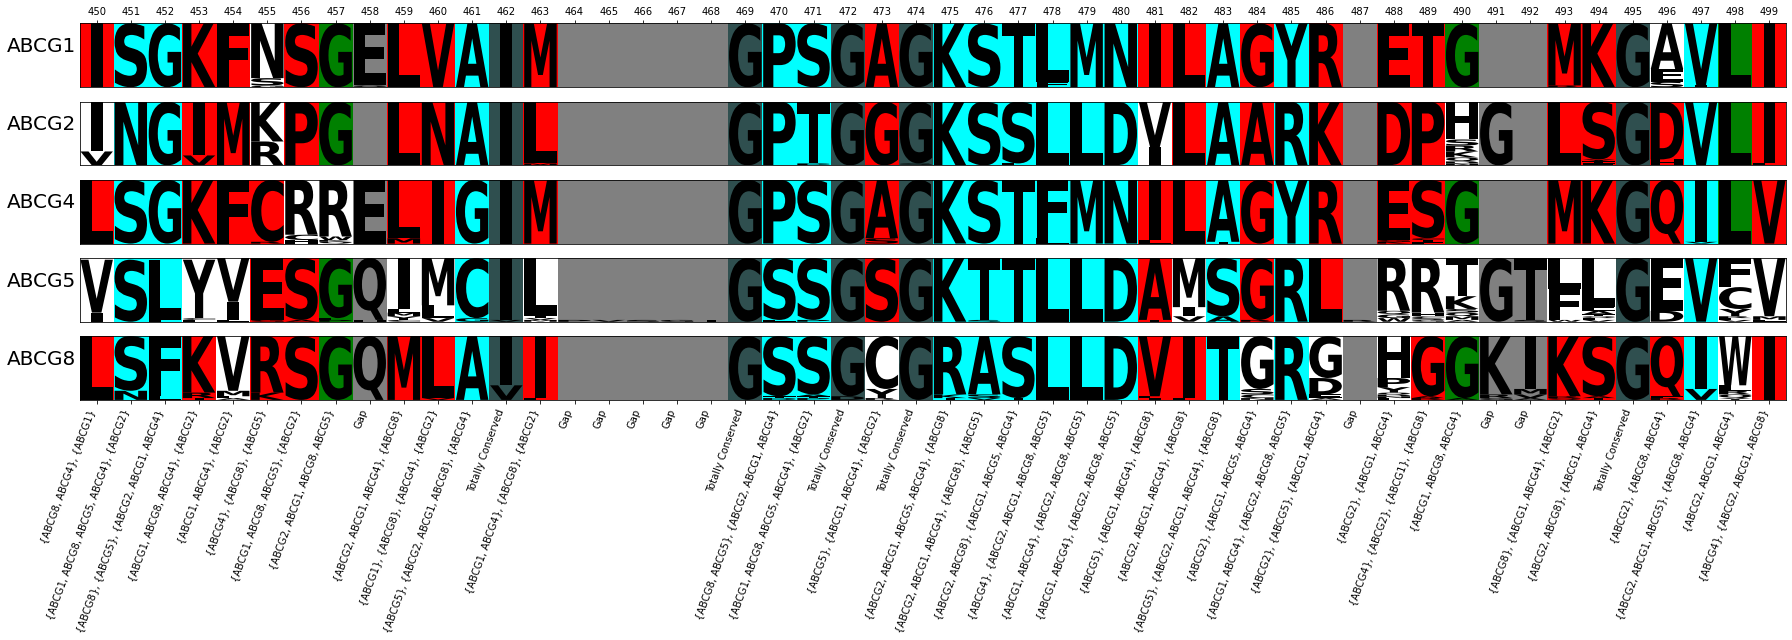

In [6]:
protein_logo(range(450,500))